<div style="width: 100%; background-color: #222; text-align: center">
<br><br>

<h1 style="color: white; font-weight: bold;">
    Project
</h1>
    
<h3 style="color: #ef7d22; font-weight: normal;">
    SDSS Dataset Classification
</h3>

<br><br> 
</div>

![orange-divider](https://user-images.githubusercontent.com/7065401/98619088-44ab6000-22e1-11eb-8f6d-5532e68ab274.png)

`Scikit-Learn` module provides several others methods for classification:

[Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

[Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html)

[Random Forest](http://scikit-learn.org/stable/modules/ensemble.html#forest)

A handy comparison of all different classification methods is given [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn import neighbors, svm, ensemble

#### SDSS dataset

SDSS is a large dataset of galaxies with spectroscopic information from the SDSS survey. This survey obtained images for 357,000,000 stars and galaxies in five photometric bands, as well as spectroscopy for 1,600,000 galaxies, quasars, and stars. AstroML provides access to a subset of this huge information. It is described [here](http://www.astroml.org/user_guide/datasets.html). The output lists various fields listed in the dataset, including galaxy positions on the sky, redshift, velocity dispersion, magnitudes in the SDSS $u$, $g$, $r$, $i$, and $z$ bands, stellar mass, star formation rate, and others.

In [2]:
# if these lines give errors, run the next two cells instead, to define the same routines
if True:
    from astroML.plotting import scatter_contour
    from astroML.plotting.tools import draw_ellipse

In [3]:
def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi, **kwargs))

In [4]:
def scatter_contour(x, y,
                    levels=10,
                    threshold=100,
                    log_counts=False,
                    histogram2d_args=None,
                    plot_args=None,
                    contour_args=None,
                    filled_contour=True,
                    ax=None):
    """Scatter plot with contour over dense regions
    Parameters
    ----------
    x, y : arrays
        x and y data for the contour plot
    levels : integer or array (optional, default=10)
        number of contour levels, or array of contour levels
    threshold : float (default=100)
        number of points per 2D bin at which to begin drawing contours
    log_counts :boolean (optional)
        if True, contour levels are the base-10 logarithm of bin counts.
    histogram2d_args : dict
        keyword arguments passed to numpy.histogram2d
        see doc string of numpy.histogram2d for more information
    plot_args : dict
        keyword arguments passed to plt.plot.  By default it will use
        dict(marker='.', linestyle='none').
        see doc string of pylab.plot for more information
    contour_args : dict
        keyword arguments passed to plt.contourf or plt.contour
        see doc string of pylab.contourf for more information
    filled_contour : bool
        If True (default) use filled contours. Otherwise, use contour outlines.
    ax : pylab.Axes instance
        the axes on which to plot.  If not specified, the current
        axes will be used
    Returns
    -------
    points, contours :
       points is the return value of ax.plot()
       contours is the return value of ax.contour or ax.contourf
    """
    x = np.asarray(x)
    y = np.asarray(y)

    default_contour_args = dict(zorder=2)
    default_plot_args = dict(marker='.', linestyle='none', zorder=1)

    if plot_args is not None:
        default_plot_args.update(plot_args)
    plot_args = default_plot_args

    if contour_args is not None:
        default_contour_args.update(contour_args)
    contour_args = default_contour_args

    if histogram2d_args is None:
        histogram2d_args = {}

    if contour_args is None:
        contour_args = {}

    if ax is None:
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        ax = plt.gca()

    H, xbins, ybins = np.histogram2d(x, y, **histogram2d_args)

    if log_counts:
        H = np.log10(1 + H)
        threshold = np.log10(1 + threshold)

    levels = np.asarray(levels)

    if levels.size == 1:
        levels = np.linspace(threshold, H.max(), levels)

    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

    i_min = np.argmin(levels)

    # draw a zero-width line: this gives us the outer polygon to
    # reduce the number of points we draw
    # somewhat hackish... we could probably get the same info from
    # the full contour plot below.
    outline = ax.contour(H.T, levels[i_min:i_min + 1],
                         linewidths=0, extent=extent,
                         alpha=0)

    if filled_contour:
        contours = ax.contourf(H.T, levels, extent=extent, **contour_args)
    else:
        contours = ax.contour(H.T, levels, extent=extent, **contour_args)

    X = np.hstack([x[:, None], y[:, None]])

    if len(outline.allsegs[0]) > 0:
        outer_poly = outline.allsegs[0][0]
        try:
            # this works in newer matplotlib versions
            from matplotlib.path import Path
            points_inside = Path(outer_poly).contains_points(X)
        except:
            # this works in older matplotlib versions
            import matplotlib.nxutils as nx
            points_inside = nx.points_inside_poly(X, outer_poly)

        Xplot = X[~points_inside]
    else:
        Xplot = X

    points = ax.plot(Xplot[:, 0], Xplot[:, 1], **plot_args)

    return points, contours

In [5]:
# if astroML give erros, switch to astropy to load the same dataset 
if True:
    from astroML.datasets import fetch_sdss_specgals
    data = fetch_sdss_specgals()
else:
    from astropy.io.fits import getdata
    data = getdata('SDSSspecgalsDR8.fit',1)

In [6]:
print(data.shape, 'spectra fields:', data.dtype.names)

(661598,) spectra fields: ('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


Lets make a common color-magnitude diagram, for the $g-r$ color vs. $r$-band magnitude. To make a cleaner dataset, we restrict the redshift range to $0.02 < z < 0.06$. This reduces the number of objects from 661598 to 114527, still a huge number for a statistical study.

114527 galaxies selected


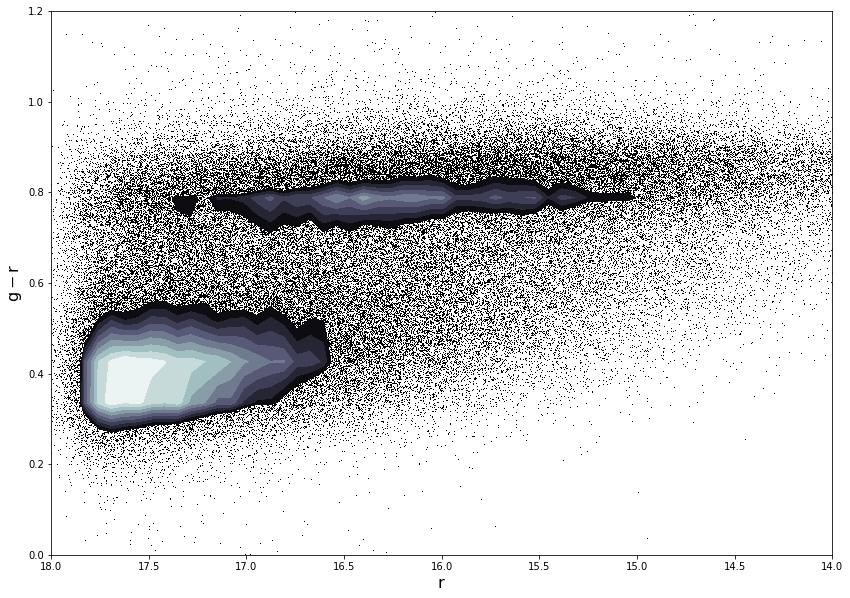

In [7]:
# redshift cut 
data = data[data['z'] > 0.02]
data = data[data['z'] < 0.06]

gr = data['modelMag_g'] - data['modelMag_r']
r = data['modelMag_r']
print(len(r), 'galaxies selected')

fig, ax = plt.subplots(figsize=(14, 10))
scatter_contour(r, gr, threshold=400, log_counts=True, ax=ax, histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='black'), contour_args=dict(cmap=plt.cm.bone))
#plt.scatter(r, gr, s=1, c='b')

ax.set_xlabel(r'${\rm r}$', size=16)
ax.set_ylabel(r'${\rm g - r}$', size=16)
ax.set_xlim(18, 14)
ax.set_ylim(0, 1.2)
plt.show()

There is a bimodality in the color distribution. The long narrow band around $g-r = 0.8$ is called *red sequence* galaxies, while the big cloud at $0.3 < g-r < 0.5$ is the *blue cloud* (star-forming) galaxies. The histogram below confirms this bimodal distribution.

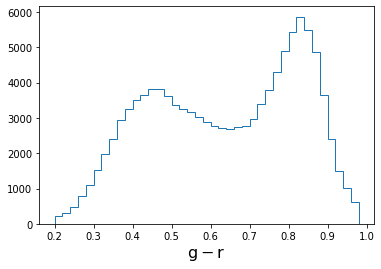

In [8]:
plt.hist(gr, bins=np.arange(0.2,1,0.02), histtype='step')
plt.xlabel(r'${\rm g - r}$', size=16)
plt.show()

However, from a much smaller dataset, it would be difficult to infer this bimodality. Let's take the first hundred galaxies and plot their color histogram:

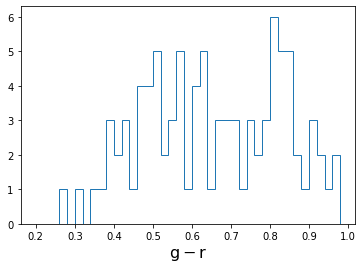

In [9]:
plt.hist(gr[:100], bins=np.arange(0.2,1,0.02), histtype='step')
plt.xlabel(r'${\rm g - r}$', size=16)
plt.show()

Here is an example of selecting the training set and the test set from our galaxy database. Let's take a relatively small number, 100 objects for the training set, and a larger number, 10000 objects for the training set.

In [37]:
X = np.vstack([r, gr]).T
print('total dataset:', X.shape, 'galaxies')

Xtraining = X[:100]
#Xtraining = X[:10000]
print('training set:', len(Xtraining), 'galaxies')

Xtest = X[-1000:]
print('test set:', len(Xtest), 'galaxies')

total dataset: (114527, 2) galaxies
training set: 100 galaxies
test set: 1000 galaxies


Let's begin our exploration of this dataset with unsupervised Gaussian Mixture Modeling, which does not require the knowledge of any labels.

best fit converged: True
number of interations = 6
BIC: N components = 2


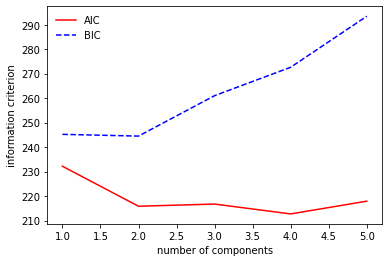

In [38]:
N = np.arange(1, 6)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i], covariance_type='full').fit(Xtraining)

AIC = [m.aic(Xtraining) for m in models]
BIC = [m.bic(Xtraining) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print('best fit converged:', gmm_best.converged_)
print('number of interations =', gmm_best.n_iter_)
print('BIC: N components = %i' % N[i_best])

plt.plot(N, AIC, 'r-', label='AIC')
plt.plot(N, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

Both information criteria prefer two modes. Let's color the points according to the predicted split of the training dataset.

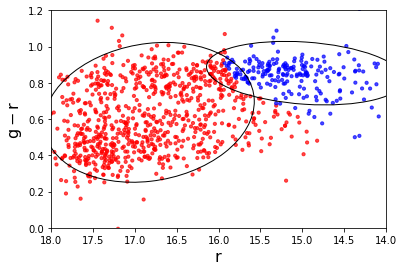

In [39]:
cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

#plt.scatter(Xtraining[:,0], Xtraining[:,1], c=gmm_best.predict(Xtraining), cmap=cmap_bold, alpha=0.7, s=10)
plt.scatter(Xtest[:,0], Xtest[:,1], c=gmm_best.predict(Xtest), cmap=cmap_bold, alpha=0.7, s=10)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)

for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='k')

Now we can predict the expected mode for any value of $r, g-r$ and color the whole space according to the predicted mode.

[]

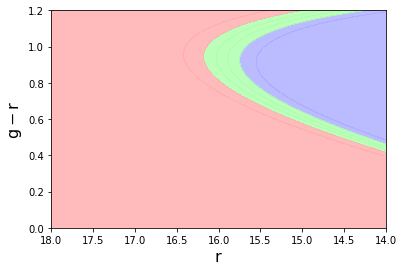

In [40]:
xx, yy = np.meshgrid(np.linspace(18,14,200), np.linspace(0,1.2,120))

Z = gmm_best.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z_GMM = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z_GMM, alpha=.8, cmap=cmap_light)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

### Nearest Neighbors

The [Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html) method could be as supervised or unsupervised.

Let's use the supervised version and assign the training labels two values (True or False) based on whether $g-r > 0.65$, which seems like a reasonable split by eye. The algorithm should refine this estimate of the boundary between the clusters, using a larger test set.

In [42]:
border = 0.65
target = (Xtraining[:,1] > border)

Scatter plot of the training set, colored by the assigned labels.

[]

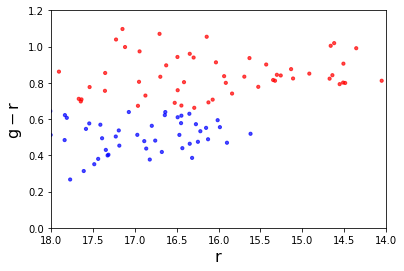

In [43]:
cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

plt.scatter(Xtraining[:,0], Xtraining[:,1], c=target, cmap=cmap_bold, alpha=0.7, s=10)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

Now we initialize the Sklearn's implementation of the [NN Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), evaluate fit for the training dataset, and predict labels for the test set. The most important parameters to choose are the number of neighbors and how their contributions are weighted.

[]

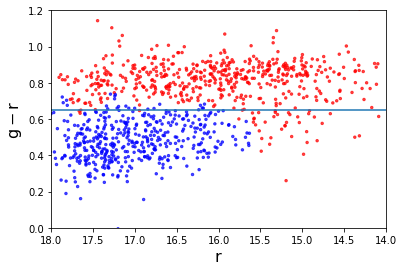

In [44]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

Close-up view near the decision boundary.

[]

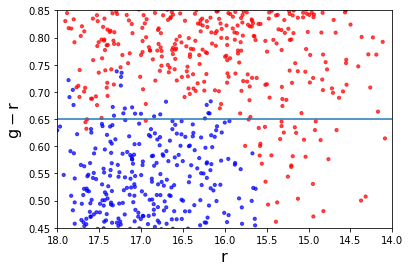

In [45]:
plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=10)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0.45,0.85)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

The following plot creates a colored map of predicted labels. Red color corresponds to points that have more than 75% probability of belonging to the red class, blue color corresponds to points that have more than 75% probability of belonging to the blue class. Green color marks the intermediate region where the classification is not as clear. 

[]

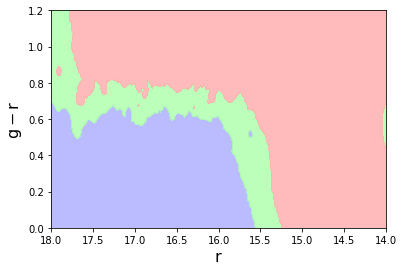

In [46]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z_NN = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z_NN, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

### Support Vector Machines

Sklearn implementation of the [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) has many options. One of the most important is choosing the kernel. Default choice is 'rbf', while 'linear' is very intuitive: it draws a straight line separating the clusters.

[]

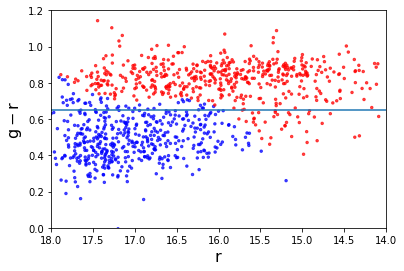

In [48]:
#clf = svm.SVC(gamma=100, kernel='linear')
clf = svm.SVC(gamma=1, kernel='rbf')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

[]

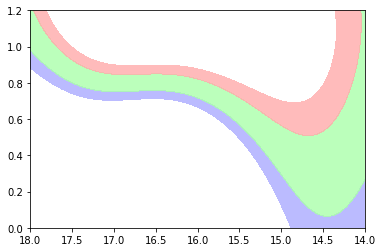

In [49]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z_SVM = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z_SVM, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.plot()

### Random Forest

The [Random Forest](http://scikit-learn.org/stable/modules/ensemble.html#forest) is a type of the decision tree algorithm.

Sklearn implementation of the [RF Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) also has many parameters, one of the most important is the number of estimators.

[]

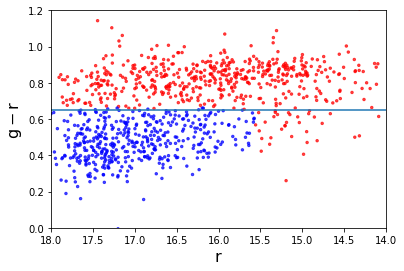

In [52]:
clf = ensemble.RandomForestClassifier(n_estimators=5)

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

[]

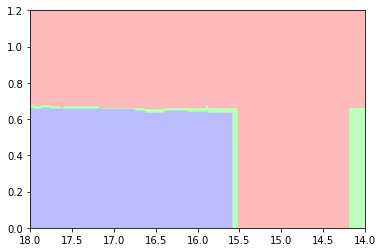

In [53]:
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z_RF = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z_RF, alpha=.8, cmap=cmap_light, levels=[0, 0.25, 0.75, 1])
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.plot()

### Using additional information

Now let's see how the performance of the classifiers changes after we include additional information about our objects.  Add the $u-i$ color and repeat the selection of the training and test sets.

In [23]:
ui = data['modelMag_u'] - data['modelMag_i']

X = np.vstack([r, gr, ui]).T
print('total dataset:', X.shape, 'galaxies')

Xtraining = X[:100]
print('training set:', len(Xtraining), 'galaxies')

Xtest = X[-1000:]
print('test set:', len(Xtest), 'galaxies')

target = (Xtraining[:,1] > border)

total dataset: (114527, 3) galaxies
training set: 100 galaxies
test set: 1000 galaxies


In [24]:
ui = data['modelMag_u'] - data['modelMag_i']
ur = data['modelMag_u'] - data['modelMag_r']
ug = data['modelMag_u'] - data['modelMag_g']
gi = data['modelMag_g'] - data['modelMag_i']

X = np.vstack([r, gr, ui, ug]).T
print('total dataset:', X.shape, 'galaxies')

Xtraining = X[:100]
print('training set:', len(Xtraining), 'galaxies')

Xtest = X[-1000:]
print('test set:', len(Xtest), 'galaxies')

target = (Xtraining[:,1] > border)

total dataset: (114527, 4) galaxies
training set: 100 galaxies
test set: 1000 galaxies


[]

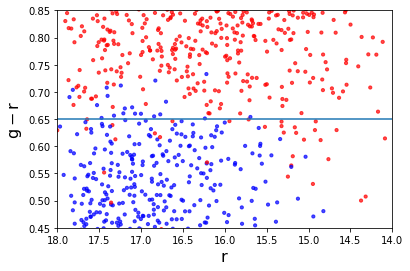

In [25]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)

# apply fit to the test data
y = clf.predict(Xtest)

plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=10)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0.45,0.85)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

In [89]:
for i,v in np.ndenumerate(Z_GMM):
    if v > .75:
        Z_GMM[i] = 1.
    elif v > .25:
        Z_GMM[i] = .5
    else:
        Z_GMM[i] = 0.
for i,v in np.ndenumerate(Z_NN):
    if v > .75:
        Z_NN[i] = 1.
    elif v > .25:
        Z_NN[i] = .5
    else:
        Z_NN[i] = 0.
for i,v in np.ndenumerate(Z_RF):
    if v > .75:
        Z_RF[i] = 1.
    elif v > .25:
        Z_RF[i] = .5
    else:
        Z_RF[i] = 0.
for i,v in np.ndenumerate(Z_SVM):
    if v > .75:
        Z_SVM[i] = 1.
    elif v > .25:
        Z_SVM[i] = .5
    else:
        Z_SVM[i] = 0.

In [113]:
points = []
for point_y in np.linspace(0,1.2,120):
    for point_x in np.linspace(18,14,200):
        points.append([point_y,point_x])

In [94]:
df_GMM = pd.DataFrame(points,columns=['x','y'])
df_GMM['Z'] = Z_GMM.flatten()
df_GMM.to_csv('GMM_prediction.csv')

In [95]:
df_NN = pd.DataFrame(points,columns=['x','y'])
df_NN['Z'] = Z_NN.flatten()
df_NN.to_csv('NN_prediction.csv')

In [96]:
df_RF = pd.DataFrame(points,columns=['x','y'])
df_RF['Z'] = Z_RF.flatten()
df_RF.to_csv('RF_prediction.csv')

In [97]:
df_SVM = pd.DataFrame(points,columns=['x','y'])
df_SVM['Z'] = Z_SVM.flatten()
df_SVM.to_csv('SVM_prediction.csv')

In [108]:
df_data = pd.DataFrame(data,columns=data.dtype.names)
df_data['modelMag_gr'] = data['modelMag_g'] - data['modelMag_r']

In [130]:
arr = np.asarray(points)
Z_GMMgr = pd.Series(dtype=np.float64)
for (r, gr) in zip(df_data['modelMag_r'], df_data['modelMag_gr']):
    nearest_idx_gr = np.where(abs(arr-gr)==abs(arr-gr).min())[0]
    ind_gr = nearest_idx_gr[0]
    ar = np.take(arr, nearest_idx, axis=0)
    nearest_idx_r = np.where(abs(ar[:,1]-r)==abs(ar[:,1]-r).min())[0]
    point = ind_gr + nearest_idx_r
    Z_GMMgr = Z_GMMgr.append(df_GMM.iloc[point]['Z'])

In [136]:
def get_z(df_z):
    Z_gr = pd.Series(dtype=np.float64)
    for (r, gr) in zip(df_data['modelMag_r'], df_data['modelMag_gr']):
        nearest_idx_gr = np.where(abs(arr-gr)==abs(arr-gr).min())[0]
        ind_gr = nearest_idx_gr[0]
        ar = np.take(arr, nearest_idx, axis=0)
        nearest_idx_r = np.where(abs(ar[:,1]-r)==abs(ar[:,1]-r).min())[0]
        point = ind_gr + nearest_idx_r
        Z_gr = Z_gr.append(df_z.iloc[point]['Z'])
    return Z_gr.to_numpy()

In [137]:
df_data['Z_GMMgr'] = get_z(df_GMM)
df_data['Z_NNgr'] = get_z(df_NN)
df_data['Z_RFgr'] = get_z(df_RF)
df_data['Z_SVMgr'] = get_z(df_SVM)

In [138]:
df_data.to_csv('data_sdss.csv')

This close-up plot is different from its version above that used only two galaxy properties. Having even one additional color measurement has reduced the abundance of red objects in the lower right part of the plot.

In general, all available information should be included to make a more robust and reliable classification.